# matchms tutorial
## part I - building a MS/MS analysis pipeline

### Requirements
For this notebook to work, `matchms` needs to be installed.
This can be done by running:

```
conda create --name matchms python=3.8
conda activate matchms
conda install --channel nlesc --channel bioconda --channel conda-forge matchms
```

# 1. Import MS/MS data
- matchms has several importing options, e.g.: `load_from_json`, `load_from_mzml`, `load_from_mzxml` etc. Here we are going to use `load_from_mgf`
- Import spectrum from mgf file downloaded from GNPS (https://gnps-external.ucsd.edu/gnpslibrary, here using `GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf`)

In [1]:
import os
import numpy as np
from matchms.importing import load_from_mgf

path_data = os.path.join(os.path.dirname(os.getcwd()), "data") #"..." enter your pathname to the downloaded file
file_mgf = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf")
spectrums = list(load_from_mgf(file_mgf))

In [2]:
print(f"{len(spectrums)} spectrums found and imported")

1267 spectrums found and imported


## Inspect spectra
- Inspect the metadata: inchikey, inchi, smiles
- Inspect the number of peaks per spectrum

In [3]:
inchikeys = [s.get("inchikey") for s in spectrums]
found_inchikeys = np.sum([1 for x in inchikeys if x is not None])
print(f"Found {int(found_inchikeys)} inchikeys in metadata")

Found 0 inchikeys in metadata


In [4]:
inchi = [s.get("inchi") for s in spectrums]
inchi[:10]

['N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A']

In [5]:
smiles = [s.get("smiles") for s in spectrums]
smiles[:10]

['OC(=O)[C@H](NC(=O)CCN1C(=O)[C@@H]2Cc3ccccc3CN2C1=O)c4ccccc4',
 'O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4',
 'COc1cc(O)c2c(=O)cc(oc2c1)c3ccccc3',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\\4/C(=O)NC(=O)N(CC=C)C4=O',
 'CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc12)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'Cc1c(Cc2ccccc2)c(=O)oc3c(C)c(OCC(=O)N[C@@H](Cc4ccccc4)C(=O)O)ccc13',
 'CC(Cc1c[nH]c2ccccc12)C(=O)O',
 'COc1ccc(CNC(=O)[C@@H](NC(=O)C2CCN(CC2)C(=O)[C@@H](N)CC(C)C)C(C)C)cc1',
 'Cc1c(Br)c(=O)oc2cc(OCC(=O)N3C[C@H]4C[C@@H](C3)c5cccc(=O)n5C4)ccc12']

Text(0, 0.5, 'Number of spectra')

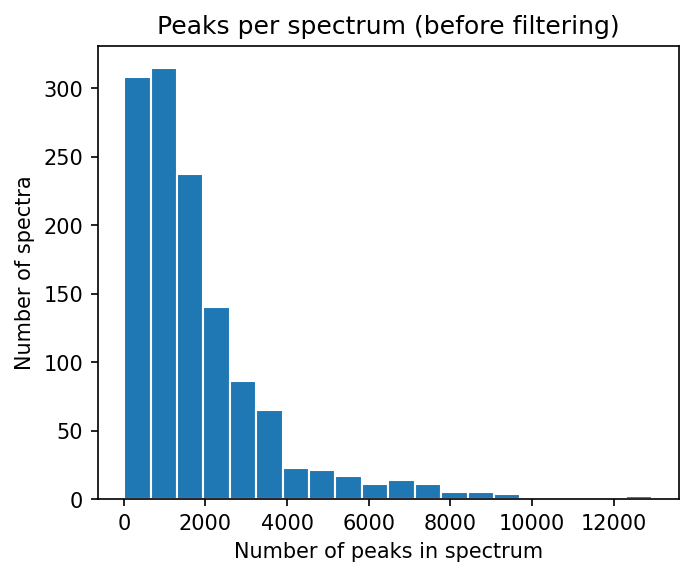

In [6]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]

from matplotlib import pyplot as plt
plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (before filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")
#plt.savefig("hist01.png")

# 2. Build a data processing pipeline
Depending on the data that you import, in most cases you might want to further process the spectra. matchms offers numerous 'filters' to process Spectrum objects. They are designed in a way that allows to simply stack them to any processing pipeline you want. In general, `matchms.filtering` contains filters that either will

- harmonize, clean, extend, and/or check the spectrum metadata
- process or filter spectrum peaks (e.g. remove low intensity peaks, or normalize peak intensities)

In [7]:
import matchms.filtering as ms_filters

def metadata_processing(spectrum):
    """Build your own custom filter/preprocessing pipeline.
    """
    spectrum = ms_filters.default_filters(spectrum)
    spectrum = ms_filters.repair_inchi_inchikey_smiles(spectrum)
    spectrum = ms_filters.derive_inchi_from_smiles(spectrum)
    spectrum = ms_filters.derive_smiles_from_inchi(spectrum)
    spectrum = ms_filters.derive_inchikey_from_inchi(spectrum)
    spectrum = ms_filters.harmonize_undefined_smiles(spectrum)
    spectrum = ms_filters.harmonize_undefined_inchi(spectrum)
    spectrum = ms_filters.harmonize_undefined_inchikey(spectrum)
    spectrum = ms_filters.add_precursor_mz(spectrum)
    return spectrum

Here we defined a sequence of filters to be applied to a spectrum, which will apply default filters (a bunch of standard operations to make metadata entries more consistent). Then we run a number of filters that look for inchi, inchikey, and smiles that ended up in wrong fields (`repair_inchi_inchikey_smiles`), and ultimately translate inchi, inchikey, and smiles into another wherever possible.


To process the peaks we define another pipeline:

### Peak processing pipeline

In [8]:
def peak_processing(spectrum):
    spectrum = ms_filters.normalize_intensities(spectrum)
    spectrum = ms_filters.select_by_intensity(spectrum, intensity_from=0.01)
    spectrum = ms_filters.select_by_mz(spectrum, mz_from=10, mz_to=1000)
    return spectrum

Here we defined a sequence of filters which will normalize the intensities to values between 0 and 1, and finally only keep peaks if they have a normalized intensity > 0.01 and if they have a m/z position between 10 and 1000 Da.


Once defined in this way, we can easily apply this processing sequence to all imported spectrums by doing:

In [9]:
spectrums = [metadata_processing(s) for s in spectrums]
spectrums = [peak_processing(s) for s in spectrums]

In [10]:
inchikeys = [s.get("inchikey") for s in spectrums]
inchikeys[:10]

['XTJNPXYDTGJZSA-PKOBYXMFSA-N',
 'VOYWJNWCKFCMPN-FHERZECASA-N',
 'IRZVHDLBAYNPCT-UHFFFAOYSA-N',
 'OPWCHZIQXUKNMP-RGEXLXHISA-N',
 'GTBYYVAKXYVRHX-BVSLBCMMSA-N',
 'UVZWLAGDMMCHPD-UHFFFAOYSA-N',
 'XKWILXCQJFNUJH-DEOSSOPVSA-N',
 'JDZNIWUNOASRIK-UHFFFAOYSA-N',
 'RCAVVTTVAJETSK-VXKWHMMOSA-N',
 'KQAZJQXFNDOORW-CABCVRRESA-N']

Text(0, 0.5, 'Number of spectra')

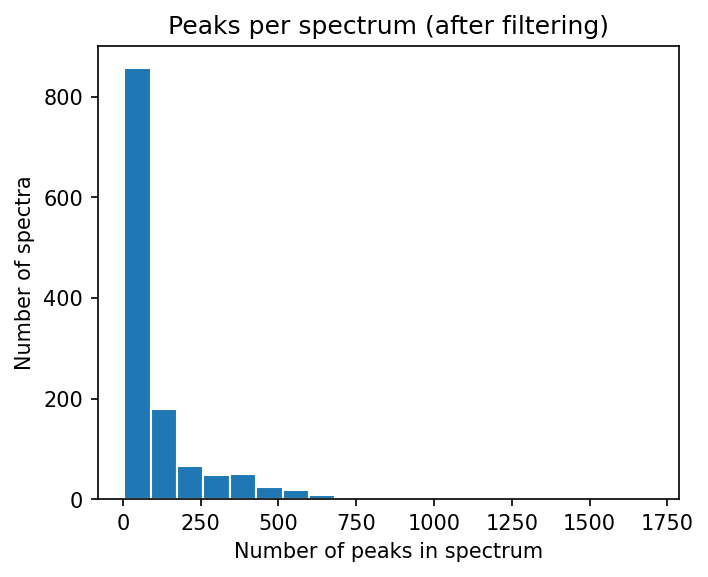

In [11]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]

from matplotlib import pyplot as plt
plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (after filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")
#plt.savefig("hist02.png")

- the filtering did drastically reduce the (initially very high) number of peaks per spectrum
- this is mostly due to the removal of peaks < 0.01 of the max intensity

## Export processed data
There are multiple options to export your data after processing. Using `save_as_json` or `save_as_mgf` the data can be written back to a `.json` or `.mgf` file.

In [12]:
from matchms.exporting import save_as_json

file_export_json = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY_processed.json")
save_as_json(spectrums, file_export_json)

A alternative that is much faster for reading/writing is to use 'pickle'. Should data handling become an issue (e.g. many thousands spectrums), than this can be a way out.

In [13]:
import pickle

file_export_pickle = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY_processed.pickle")
pickle.dump(spectrums, 
            open(file_export_pickle, "wb"))

# 3. Compute spectra similarities : Cosine score
In the following part the Cosine similarity scores between all possible spectra pairs will be calculated.

In [14]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy

similarity_measure = CosineGreedy(tolerance=0.005)
scores = calculate_scores(spectrums, spectrums, similarity_measure, is_symmetric=True)

### Results come as `Scores` object!
Matchms returns the results of all score computations as a `Scores` object. 
The Scores object contains the spectrums which were used as well as the computed similarity scores. It also allows to query the most similar spectra.

In [15]:
scores.scores.shape  # ,2 because CosineGreedy returns two scores --> Cosine score and number of matching peaks

(1267, 1267, 2)

**Important: The Scores object has changed in matchms >= 0.18.0** 
Since version 0.18.0, the computed scores are stored in a *sparse array*. This means that for very large computations it won't have to also store scores which are 0 (or False).

In [16]:
scores.scores

<1267x1267x2 stacked sparse array containing scores for ('CosineGreedy_score', 'CosineGreedy_matches') with 964913 stored elements in COOrdinate format>

## How to get the scores out of `Scores`?
To get all scores as a Numpy array (similar to how the outcome looked before matchms 0.18.0), we can use the `to_array()` method.

In [17]:
scores_array = scores.scores.to_array()
scores_array[:5, :5]["CosineGreedy_score"]

array([[1.00000000e+00, 6.41050958e-03, 1.70386100e-04, 8.59172648e-04,
        2.35757313e-03],
       [6.41050958e-03, 1.00000000e+00, 1.37105333e-02, 9.45693252e-01,
        9.17922823e-05],
       [1.70386100e-04, 1.37105333e-02, 1.00000000e+00, 1.53604286e-02,
        0.00000000e+00],
       [8.59172648e-04, 9.45693252e-01, 1.53604286e-02, 1.00000000e+00,
        0.00000000e+00],
       [2.35757313e-03, 9.17922823e-05, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00]])

In [18]:
scores_array[:5, :5]["CosineGreedy_matches"]

array([[40,  2,  1,  4,  1],
       [ 2, 75,  2,  5,  1],
       [ 1,  2, 37,  4,  0],
       [ 4,  5,  4, 66,  0],
       [ 1,  1,  0,  0, 43]])

In [19]:
# Individual scores can also be accessed directly from a Scores object:
scores.scores[5, 5]

array([(1., 30)],
      dtype=[('CosineGreedy_score', '<f8'), ('CosineGreedy_matches', '<i4')])

## Get highest scoring results for a spectrum of interest
Scores allows to get the corresponding scores for a query/reference spectrum. If multiple scores exist (such as in our case where we have Cosine-score and matches), the desired score to sort for needs to be specified.

To get the names of the available (already computed) scores, we can use `.score_names`:

In [20]:
scores.score_names

('CosineGreedy_score', 'CosineGreedy_matches')

In [21]:
# Get top 10 results for Cosine-score
best_matches = scores.scores_by_query(spectrums[5], name="CosineGreedy_score", sort=True)[:10]
[x[1] for x in best_matches]

[(1., 30),
 (0.99711049, 2),
 (0.99534901, 2),
 (0.99214557, 2),
 (0.98748381, 2),
 (0.98461111, 3),
 (0.98401833, 2),
 (0.97598497, 2),
 (0.9757458, 2),
 (0.97547771, 2)]

In [22]:
# Get top 10 results for peak matches
best_matches2 = scores.scores_by_query(spectrums[5], name="CosineGreedy_matches", sort=True)[:10]
[x[1] for x in best_matches2]

[(1., 30),
 (0.01924283, 7),
 (0.44857215, 6),
 (0.00840952, 6),
 (0.00502379, 6),
 (0.00666929, 6),
 (0.03942863, 6),
 (0.0179647, 5),
 (0.00082445, 5),
 (0.0187628, 5)]

In [23]:
[x[0].get("smiles") for x in best_matches]

['OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'Cc1cc(=O)oc2cc(OC(=O)c3ccccc3)ccc12',
 'O=C(Nc1ccccc1OC(=O)c2ccccc2)c3ccccc3',
 'COc1cc(CC=C)ccc1OC(=O)c2ccccc2',
 'O=C(OCC1OC(C(OC(=O)c2ccccc2)C1OC(=O)c3ccccc3)n4ncc(=O)[nH]c4=O)c5ccccc5',
 'O=C(Oc1cccc2ccccc12)c3ccccc3',
 'O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4',
 'COC(=O)CNC(=O)c1ccccc1',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1C=C4C(=O)NC(=O)NC4=O',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\\4/C(=O)NC(=O)N(C)C4=O']

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

## Alternative: Get highest scoring results above min_match criteria

In [25]:
min_match = 5
sorted_matches = scores.scores_by_query(spectrums[5], name="CosineGreedy_score", sort=True)
best_matches = [x for x in sorted_matches if x[1]["CosineGreedy_matches"] >= min_match][:10]
[x[1] for x in best_matches]

[(1., 30),
 (0.44857215, 6),
 (0.39605775, 5),
 (0.33880658, 5),
 (0.03942863, 6),
 (0.03429136, 5),
 (0.03028157, 5),
 (0.02845932, 5),
 (0.01924283, 7),
 (0.01890612, 5)]

## Computing spectra similarities between all spectra - Modified Cosine score
In the following part the **Modified Cosine similarity** scores (Watrous et al., 2012) between all possible spectra pairs will be calculated.

The modified cosine score aims at quantifying the similarity between two
mass spectra. The score is calculated by finding best possible matches between
peaks of two spectra. Two peaks are considered a potential match if their
m/z ratios lie within the given 'tolerance', or if their m/z ratios
lie within the tolerance once a mass-shift is applied. The mass shift is
simply the difference in precursor-m/z between the two spectra.
See Watrous et al. [PNAS, 2012, https://www.pnas.org/content/109/26/E1743]
for further details.

In [26]:
# Careful --> this computation may take a while!
from matchms.similarity import ModifiedCosine

similarity_measure = ModifiedCosine(tolerance=0.005)
scores = calculate_scores(spectrums, spectrums, similarity_measure, is_symmetric=True)

In [27]:
min_match = 5
sorted_matches = scores.scores_by_query(spectrums[5], name="ModifiedCosine_matches", sort=True)
best_matches = [x for x in sorted_matches if x[1]["ModifiedCosine_matches"] >= min_match][:10]
[x[1] for x in best_matches]

[(1., 30),
 (0.01958512, 9),
 (0.00866656, 9),
 (0.00940183, 8),
 (0.00453957, 8),
 (0.00175019, 7),
 (0.00674538, 7),
 (0.03060675, 7),
 (0.0029307, 7),
 (0.00979578, 7)]

Text(0, 0.5, 'Spectrum #ID')

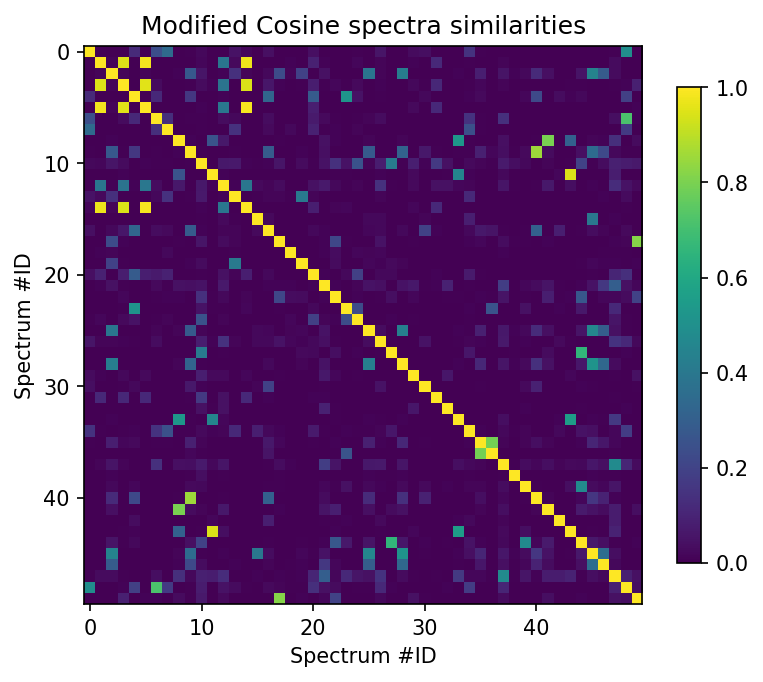

In [28]:
scores_array = scores.scores.to_array()

plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array[:50, :50]["ModifiedCosine_score"], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Modified Cosine spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
#plt.savefig("modified_cosine_scores.png")

Text(0, 0.5, 'Spectrum #ID')

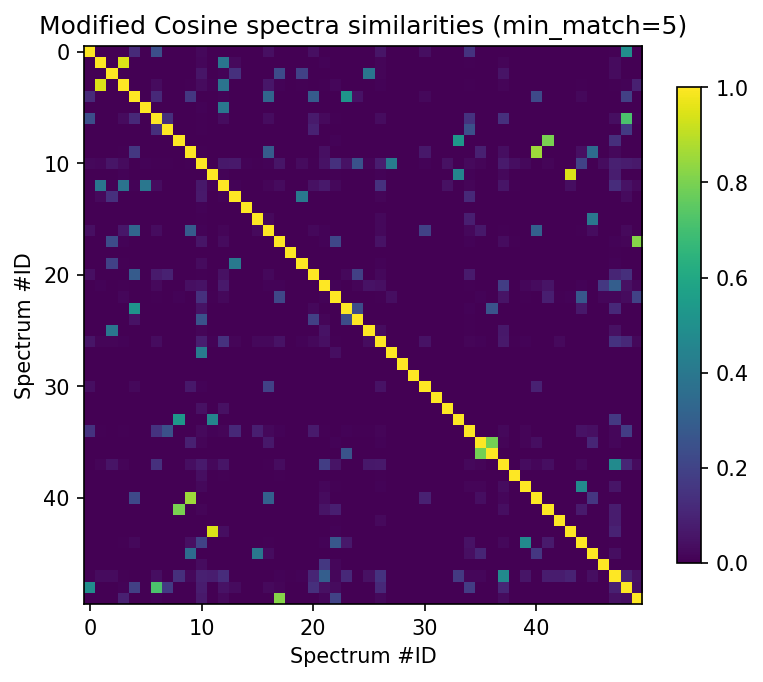

In [29]:
min_match = 5

plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array[:50, :50]["ModifiedCosine_score"] \
           * (scores_array[:50, :50]["ModifiedCosine_matches"] >= min_match), cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Modified Cosine spectra similarities (min_match=5)")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
#plt.savefig("modified_cosine_scores_min_match5.png")

This suggests that -for instance- `spectrums[11]` seems to have several related other ones among the first 50 spectrums. Let's have a closer look at it.

In [30]:
min_match = 5
sorted_matches = scores.scores_by_query(spectrums[11], name="ModifiedCosine_score", sort=True)
best_matches = [x for x in sorted_matches if x[1]["ModifiedCosine_matches"] >= min_match][:10]
[x[1] for x in best_matches]

[(1., 151),
 (0.95295779, 15),
 (0.94542762, 13),
 (0.89735889, 17),
 (0.7886489, 12),
 (0.77433041, 9),
 (0.74935776, 8),
 (0.72854032, 8),
 (0.55896333, 7),
 (0.52331993, 9)]

In [31]:
[x[0].get("smiles") for x in best_matches]

['CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CC(=O)O)C(=O)O',
 'CCCCCC(NC(=O)C1CCN(CC1)C(=O)[C@@H](NS(=O)(=O)c2ccc(C)cc2)C(C)C)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CCC(=O)N)C(=O)O',
 'COC(=O)C1CCN(CC1)C(=O)C2CCN(CC2)C(=O)[C@@H](NS(=O)(=O)c3ccc(C)cc3)C(C)C',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](C(C)C)C(=O)O',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)N',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)OC']

### Plot the compounds with the highest modified Cosine score

In [32]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

## Inspect a case that doesn't work that well...

In [33]:
masses = [s.get("precursor_mz") for s in spectrums]

In [34]:
np.where(np.array(masses) > 600)

(array([  12,   84,   97,  104,  105,  156,  469,  470,  532,  533,  602,
         604,  708,  853, 1010, 1060, 1085, 1097, 1117, 1265], dtype=int64),)

In [35]:
min_match = 5
sorted_matches = scores.scores_by_query(spectrums[97], name="ModifiedCosine_score", sort=True)
best_matches = [x for x in sorted_matches if x[1]["ModifiedCosine_matches"] >= min_match][:10]
[x[1] for x in best_matches]

[(1., 733),
 (0.65230153, 8),
 (0.40915412, 14),
 (0.40722733, 81),
 (0.40374948, 54),
 (0.38470292, 59),
 (0.3423652, 30),
 (0.3292672, 6),
 (0.32810433, 12),
 (0.32173948, 5)]

In [36]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")